## Анализ сервиса проката самокатов GoFast

#### Цель иследования

Необходимо проверить гипотезы:
1. Тратят ли пользователи с подпиской больше времени на поездки?
2. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.
4. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

#### Ход иследования

Заказчик предоставил нам три датафрейма:
1. Общие сведенья о клиентах '/datasets/users_go.csv'
2. Все поездки клиентов '/datasets/rides_go.csv'
3. Информация о типах подписки и их спецификация '/datasets/subscriptions_go.csv'

Необходимо ознакомиться с данными всех датафреймов, выявить пропуски/ошибки/дубликаты и обработать их для более точного дальнейшего анализа.

Также необходимо объеденить все таблицы и добавить необходимые столбцы для дальнейших расчетов. Провести визуализацию данных, чтобы увидеть их распределение и сделать необходимые выводы.

В конце анализа, нужно проверить вышеперечисленные гипотезы.

Поэтому анализ будет проходить в шесть этапов:
1. Обзор данных датафреймов
2. Предобработка данных
3. Визуализация данных
4. Объединение таблиц
5. Добавление новых данных(столбцов)
6. Проверка гипотез



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
df_users = pd.read_csv('/datasets/users_go.csv')
df_rides = pd.read_csv('/datasets/rides_go.csv')
df_sub = pd.read_csv('/datasets/subscriptions_go.csv')

Изучим каждый датафрейм отдельно.

In [3]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
df_users.head(5)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [5]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
df_rides.head(5)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [7]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


In [8]:
df_sub

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Промежуточный вывод: 

Во всех трёх датафреймах отсутствуют пропуски. Необходимо ознакомиться с данными и проверить их на дубликаты.

#### Шаг 2. Предобработка данных

In [9]:
#приведём столбец date к типу даты pandas и проверим через info()
df_rides['date'] = pd.to_datetime(df_rides['date'], format='%Y-%m-%d')
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [10]:
#создадим новый столбец с номером месяца на основе столбца date
df_rides['month'] = df_rides['date'].dt.month
display(df_rides.head(10))

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


In [11]:
df_rides['year'] = df_rides['date'].dt.year
df_rides['year'].unique()

array([2021])

In [12]:
df_rides.sort_values('duration')

,user_id,distance,duration,date,month,year
12013,1102,4602.122401,0.500000,2021-08-01,8,2021
17314,1483,4445.481070,0.500000,2021-03-06,3,2021
15029,1318,5894.633314,0.500000,2021-03-28,3,2021
7437,766,4539.088310,0.500000,2021-12-22,12,2021
12967,1172,4907.140751,0.500000,2021-12-19,12,2021
...,...,...,...,...,...,...
6453,694,4210.871467,38.265229,2021-03-11,3,2021
1998,216,4831.339954,38.352763,2021-05-11,5,2021
2623,278,4754.433686,39.526602,2021-12-02,12,2021
4709,507,4645.642671,39.873856,2021-01-15,1,2021


In [13]:
#огруглим значения столбцов duration и distance
df_rides['distance'] = df_rides['distance'].round(2)
df_rides['duration'] = np.ceil(df_rides['duration']) 

df_rides.head(5)

,user_id,distance,duration,date,month,year
0,1,4409.92,26.0,2021-01-01,1,2021
1,1,2617.59,16.0,2021-01-18,1,2021
2,1,754.16,7.0,2021-04-20,4,2021
3,1,2694.78,19.0,2021-08-11,8,2021
4,1,4028.69,27.0,2021-08-28,8,2021


In [14]:
#проверяем датафреймы на наличие дубликатов
print(df_users.duplicated().sum())
print(df_rides.duplicated().sum())
print(df_sub.duplicated().sum())

31
0
0


Как видим, в датафрейме с пользователями есть дубликаты, изучим данные столбцов и избавимся от дубликатов.

In [15]:
df_users['user_id'].unique()

array([   1,    2,    3, ..., 1532, 1533, 1534])

In [16]:
df_users['name'].unique()

array(['Кира', 'Станислав', 'Алексей', 'Константин', 'Адель', 'Регина',
       'Игорь', 'Юрий', 'Ян', 'Валерий', 'Агата', 'Марк', 'Ева',
       'Антонина', 'Валерия', 'Амалия', 'Даниил', 'Аделина', 'Святогор',
       'Борис', 'Вероника', 'Ростислав', 'Назар', 'Эдуард', 'Василий',
       'Денис', 'Тамара', 'Николай', 'Эвелина', 'Федор', 'Руслан', 'Иван',
       'Любовь', 'Ярослава', 'Майя', 'Ильдар', 'Данила', 'Нина',
       'Стефания', 'Ясмина', 'Дмитрий', 'Александр', 'Одиссей', 'Арсений',
       'Алла', 'Таисия', 'Максим', 'Юлиана', 'Павел', 'Карина', 'Алиса',
       'Лидия', 'Рамиль', 'Родион', 'Ника', 'Оксана', 'Анастасия',
       'Маргарита', 'Вера', 'Тимур', 'Никита', 'Лев', 'Влад', 'Артур',
       'Анна', 'Ольга', 'Вячеслав', 'Ксения', 'Виталина', 'Владислав',
       'Тамерлан', 'Амина', 'Вадим', 'Олеся', 'Зарина', 'Егор', 'Гордей',
       'Лилия', 'Святослав', 'Роберт', 'Амир', 'Влада', 'Богдан',
       'Полина', 'Марат', 'Елисей', 'Макар', 'Алина', 'Глеб', 'Андрей',
       'Ал

In [17]:
df_users['age'].unique()

array([22, 31, 20, 26, 28, 25, 23, 21, 18, 27, 24, 29, 32, 14, 19, 30, 17,
       12, 35, 33, 13, 15, 37, 16, 34, 38, 36, 39, 43])

In [18]:
df_users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [19]:
df_users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

In [20]:
#удаляем явные дубликаты
df_users = df_users.drop_duplicates(keep='first')
print(df_users.duplicated().sum())

0


#### Промежуточный вывод:
1. Привели столбец date из датафрейма df_rides в формат datetime и в нём же добавили столбец month для дальнейшего анализа.
2. Во всех трёх датафреймах не были обнаружены неявные дубликаты.
3. В df_users были выявлены дубликаты в количестве 31 и удалены из датафрейма. Их причины возникновения могут быть: повторная регистрация пользователя на сайте.

#### Шаг 3. Исследовательский анализ данных

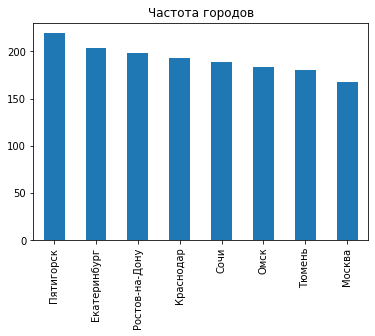

In [21]:
#построим график для столбца city и проверим частоту встречаемости городов
df_users['city'].value_counts().plot(kind='bar', title='Частота городов')
plt.show()

Изучив график, можем сделать вывод: чаще всего в датафрейме встречается город Пятигорск, наименьше - Москва. Видимо в Москве пользуются популярностью другие приложения для аренды самокатов.

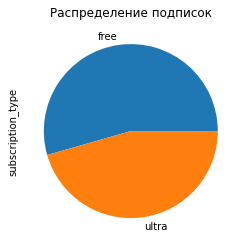

In [22]:
#построим график соотношения пользователей с подпиской и без подписки
df_users['subscription_type'].value_counts().plot(kind='pie', title='Распределение подписок')
plt.show()

In [23]:
(df_users[df_users['subscription_type'] == 'free'].count()) / len(df_users)

user_id              0.544329
name                 0.544329
age                  0.544329
city                 0.544329
subscription_type    0.544329
dtype: float64

Изучив график, можем сделать вывод: количество пользователей с подпиской и без практически одинаково; пользователей без подписки на 4.43% больше.

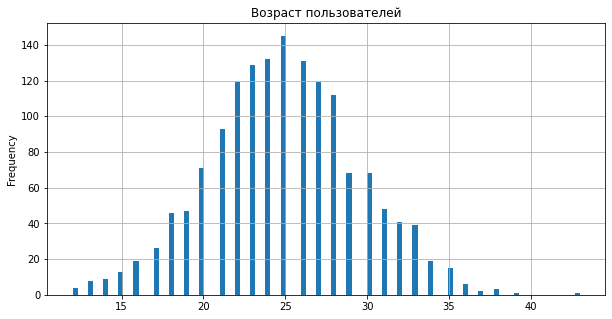

In [24]:
#построим график для возраста пользователей
df_users['age'].plot(kind='hist', bins=100, grid=True, title='Возраст пользователей', figsize=(10,5))
plt.show()

Изучив график, можем сделать вывод: целевой аудиторией приложения GoFast - являются пользователи в возрасте 25 лет.

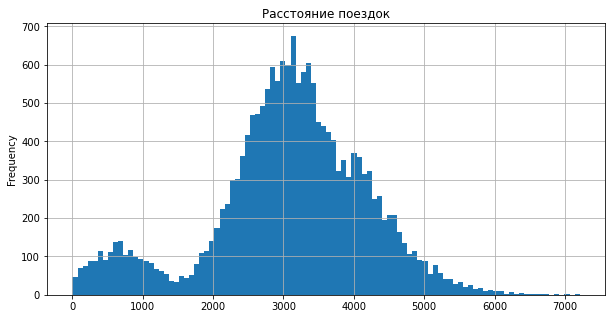

In [25]:
#построим график расстояния, которое пользователь преодолел за одну поездку
df_rides['distance'].plot(kind='hist', bins=100, grid=True, title='Расстояние поездок', figsize=(10,5))
plt.show()

Изучив график, можем сделать вывод: чаще всего пользователи проезжают расстояние приблизительно в 3.2 км за одну поездку. Однако в графике есть выбросы, необходимо их изучить и удалить из датафрейма.

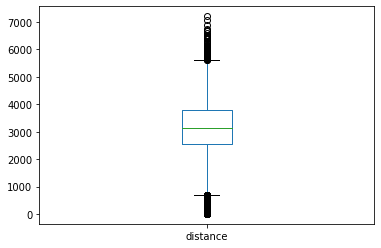

In [26]:
df_rides['distance'].plot(kind='box')
plt.show()

Из графика видно, что выбросы составляют слишком короткие поездки (менее 1 км) и слишком большие (более 5.5 км).

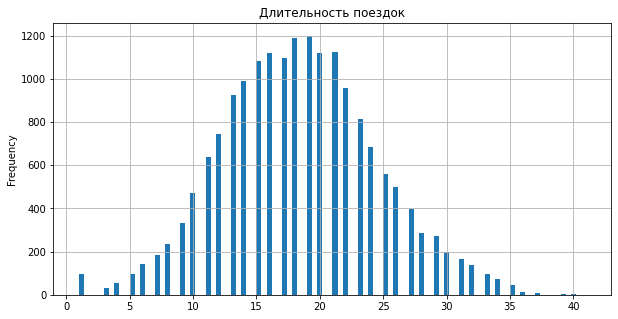

In [29]:
#построим график продолжительности поездок
df_rides['duration'].plot(kind='hist', bins=100, grid=True, title='Длительность поездок', figsize=(10,5))
plt.show()

Изучив график, можем сделать вывод: чаще всего длительность поездки пользователей составляет 17-18 минут.

Также на графике мы видим выбросы, необходимо их изучить и удалить из датафрейма.

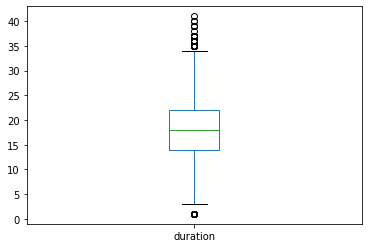

In [30]:
df_rides['duration'].plot(kind='box')
plt.show()

Видно, что выбросы составляют 0.5 минут и более 30 минут. Ранее мы выявили аномалии в виде 0.5 минут, теперь они отобразились тут на графике.

#### Промежуточный вывод:
1. Согласно визуализированным данным, можем сделать вывод: больше всего зарегистрированных пользователей, приложения GoFast, из города Пятигорск; возраст от 21-28 лет; без подписки. Чаще всего поездка длится 17-18 минут и расстояние составляет около 3.2 км.
2. В датафрейм df_rides были выявлены выбросы в виде слишком коротких поездок (менее 1 км) и слишком длинных (более 5.5 км), соответственно в длительности поездок также были выбросы.

#### Шаг 4. Объединение данных

In [33]:
df_users.shape

(1534, 5)

In [34]:
df_rides.shape

(18068, 6)

In [35]:
#объеденим первую и вторую таблицу по столбцу user_id
df1 = df_users.merge(df_rides, on='user_id', how='left')
df1.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,year
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,2021
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,2021
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,2021
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,2021
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,2021


In [36]:
df1.shape

(18068, 10)

In [37]:
df_sub.shape

(2, 4)

In [38]:
#к данной таблице добавим третий датафрейм по стобцу 'subscription_type'
df_total = df1.merge(df_sub, on='subscription_type', how='left')
df_total.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,2021,6,0,199


In [39]:
df_total.shape

(18068, 13)

Все столбцы присоедены, теперь можем создать два датафрейма с пользователями ultra и free для дальнейшего анализа.

In [40]:
#создадим датафрейм с пользователями без подписки
df_free = df_total.query('subscription_type == "free"')
df_free.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15.0,2021-01-02,1,2021,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17.0,2021-02-01,2,2021,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21.0,2021-02-04,2,2021,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10.0,2021-02-10,2,2021,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18.0,2021-02-14,2,2021,8,50,0


In [41]:
#создадим датафрейм с пользователями с подпиской
df_ultra = df_total.query('subscription_type == "ultra"')
df_ultra.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,2021,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,2021,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,2021,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,2021,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,2021,6,0,199


Построим графики расстояния и длительности поездок для двух новых датафреймов.

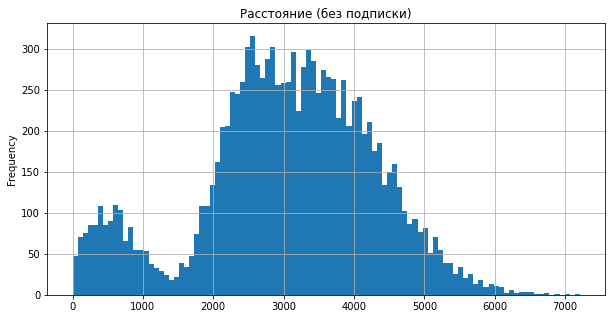

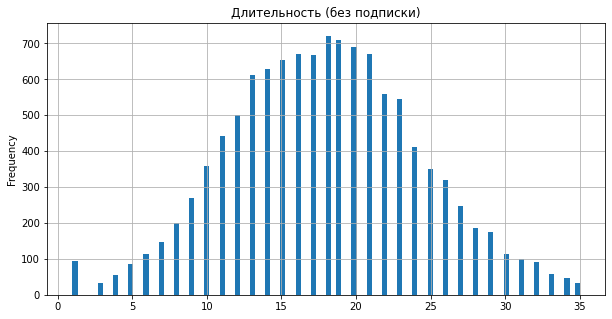

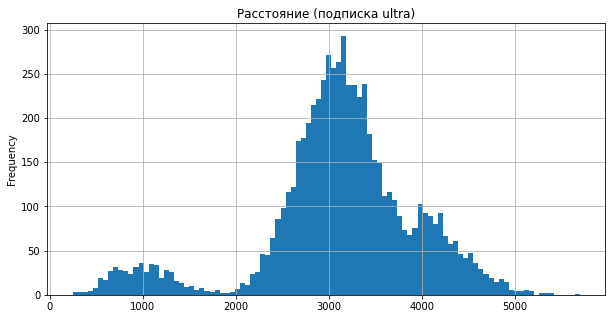

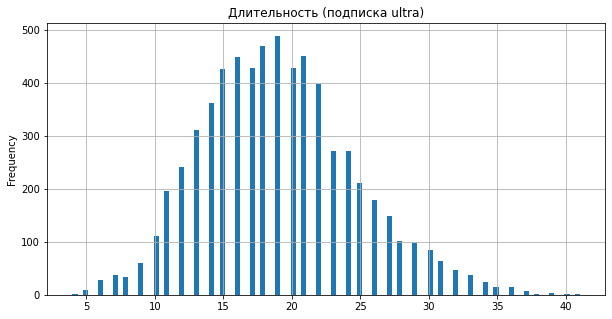

In [42]:
df_free['distance'].plot(kind='hist', bins=100, grid=True, title='Расстояние (без подписки)', figsize=(10,5))
plt.show()
df_free['duration'].plot(kind='hist', bins=100, grid=True, title='Длительность (без подписки)', figsize=(10,5))
plt.show()

df_ultra['distance'].plot(kind='hist', bins=100, grid=True, title='Расстояние (подписка ultra)', figsize=(10,5))
plt.show()
df_ultra['duration'].plot(kind='hist', bins=100, grid=True, title='Длительность (подписка ultra)', figsize=(10,5))
plt.show()

#### Промежуточный вывод:
1. Объеденили все три датафрейма в одну таблицу для дальнейшего анализа.
2. Визуализировали данные по двум таблицам: клиенты с подпиской (ultra) и без (free). Как видно из графиков, длительность поездки для обоих категорий не слишком отличается, клиенты ultra меньше ездят менее 10 минут чем клиенты free; а вот дистанции поездок имеют явные отличия: у клиентов free дистанция имеет больший диапазон (много клиентов ездят от 2 до 4.5 км), тем временем как клиенты ultra в основном ездят в пределах 2.5-3.5 км.

#### Шаг 5. Подсчёт выручки

Пропусков в таблице нет, можем приступать к подготовке сводной таблицы.

In [44]:
#создадим датафрейм с суммарным расстоянием, количество поездок 
#и суммарное время для каждого пользователя за каждый месяц

df_cash = pd.pivot_table(df_total,
                        index=["user_id", "month", "subscription_type"],
                        values=["distance", "duration", "name"],
                        aggfunc={'distance' : 'sum', 'duration' : 'sum', 'name' : 'count'}
                        ).reset_index()
df_cash = df_cash.rename(columns={'name':'total_rides'})

df_cash.head(15)

,user_id,month,subscription_type,distance,duration,total_rides
0,1,1,ultra,7027.51,42.0,2
1,1,4,ultra,754.16,7.0,1
2,1,8,ultra,6723.47,46.0,2
3,1,10,ultra,5809.91,32.0,2
4,1,11,ultra,7003.50,56.0,3
5,1,12,ultra,6751.63,28.0,2
6,2,3,ultra,10187.73,63.0,3
7,2,4,ultra,6164.39,40.0,2
8,2,6,ultra,3255.34,14.0,1
9,2,7,ultra,6780.73,48.0,2


In [45]:
#добавим столбец с помесячной выручкой, которую принёс каждый пользователь
def money(df_cash):
    if df_cash['subscription_type'] == 'ultra':
        total = 6 * df_cash['duration']+ 199
        return total
    else:
        total2 = 50 * df_cash['total_rides'] + 8 * df_cash['duration']
        return total2
    
df_cash['total_money'] = df_cash.apply(money, axis=1)
df_cash.head(15)

,user_id,month,subscription_type,distance,duration,total_rides,total_money
0,1,1,ultra,7027.51,42.0,2,451.0
1,1,4,ultra,754.16,7.0,1,241.0
2,1,8,ultra,6723.47,46.0,2,475.0
3,1,10,ultra,5809.91,32.0,2,391.0
4,1,11,ultra,7003.50,56.0,3,535.0
5,1,12,ultra,6751.63,28.0,2,367.0
6,2,3,ultra,10187.73,63.0,3,577.0
7,2,4,ultra,6164.39,40.0,2,439.0
8,2,6,ultra,3255.34,14.0,1,283.0
9,2,7,ultra,6780.73,48.0,2,487.0


#### Шаг 6. Проверка гипотез

###### Гипотеза №1: Тратят ли пользователи с подпиской больше времени на поездки?

Нулевая гипотеза: длительность поездки пользователей с подпиской и без одинакова.

Альтернативная гипотеза:длительность поездки пользователей с подпиской больше чем пользователей без подписки.

У нас есть два датафрейма df_ultra и df_free, которые мы можем сравнить между собой с помощью ttest_ind.

In [46]:
alpha = 0.05

results = st.ttest_ind(
    df_ultra['duration'],
    df_free['duration'],
    alternative='greater')

print('p-value равно:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Пользователи ultra в среднем ездят:', df_ultra['duration'].mean().round(2), 'минут')
print('А пользователи без подписки в среднем ездят:', df_free['duration'].mean().round(2), 'минут')

p-value равно: 2.4959453720736625e-34
Отвергаем нулевую гипотезу
Пользователи ultra в среднем ездят: 19.04 минут
А пользователи без подписки в среднем ездят: 17.89 минут


###### Гипотеза №2: Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

У нас дано оптимальное расстояние 3130 метров, с точки зрения износа самоката.

Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской равно оптимальному расстоянию. 

Альтернативная - проезжают больше.

Ранее мы создали датафрейм клиентов с подпиской df_ulta, по этому гипотезу проверим с помощью ttest_1samp.

In [47]:
optimal = 3130
alpha = 0.05
results = st.ttest_1samp(
    df_ultra['distance'],
    optimal,
    alternative='greater')

print('p-значение равно:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('Пользователи с подпиской в среднем проезжают:', df_ultra['distance'].mean().round(2), 'метров')

p-значение равно: 0.9195362605842414
Не получилось отвергнуть нулевую гипотезу
Пользователи с подпиской в среднем проезжают: 3115.45 метров


###### Гипотеза №3: Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза: Помесячная выручка от пользователей с подпиской и без - одинковая.

Альтернативная гипотеза: Помесячная выручка от пользователей с подпиской больше чем от пользователей без подписки.

Для этого используем метод ttest_ind.

In [48]:
data1 = df_cash.query('subscription_type == "ultra"')
data2 = df_cash.query('subscription_type == "free"')

In [49]:
alpha = 0.05
results = st.ttest_ind(
    data1['total_money'],
    data2['total_money'],
    alternative='greater')

print('p-value равно:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

print('Средняя выручка за месяц от пользователей с подпиской равно:', sum(data1['total_money']) / 12, 'рублей')
print('Средняя выручка за месяц от пользователей без подписки равно:', sum(data2['total_money']) / 12, 'рублей')

p-value равно: 1.8850394384715216e-31
Отвергаем нулевую гипотезу
Средняя выручка за месяц от пользователей с подпиской равно: 137044.75 рублей
Средняя выручка за месяц от пользователей без подписки равно: 186175.33333333334 рублей


Как видим, пользователи с подпиской не приносят больше денег, чем пользователи без подписки, что в принципе разумно, так как подписка подразумевает под собой экономию денег для пользователя.

## Итоговый вывод:

##### Предобработка данных:

В ходе анализа,  не были выявлены пропуски в трёх тадафреймах, но выявлены дублиаты в users_go в количестве 31. Дубликаты были удалены из датафрейма.

##### Рекомендации и замечания:

Необходимо обратить внимание на дубликаты в users_go и их причину образования: повторная регистрация, покупка подписки? Желательно чтобы данные пользователя при изминении автоматически обновлялись,  а не дублировали друг друга, так как количество пользователей приложения будет отображаться неверно. 

Следует в срочном порядке передать информацию разработчикам касательно длительности поездок менее 1 минут, так как расстояние, которое проехал самокат более 2 км не соответствует длительность, скорее всего на некоторых самокатах технический сбой или баг в программе.

##### Решение задачи:

После проверки гипотез, мы выяснили, что пользователи с подпиской:
1. По времени ездят дольше практически на 1 минуту чем пользователи без подписки;
2. Средняя дистанция поездки превышает оптимальное расстояние, с точки зрения износа самоката, на 72 метра.
3. Помесячный доход пользователей меньше чем пользователей без подписки.

##### Рекомендации по развитию приложения:

Несмотря на то, что пользователи с подпиской приносят меньше дохода, чем пользователи без подписки, что является логично, так как подписка подразумевает под собой экономию денег для клиента, они являются очень значимыми для компании, так как покупая подписку - компания получает постоянного клиента. Чтобы больше привлечь к себе постоянных клиентов, которые увеличивать среднемесячный доход, можно применить следующие шаги:
1. Пробная подписка на месяц для пользователей без подписки и новых клиентов.
2. Применение бонусной системы (баллов) при длительных поездах (более 20 минту) и возможность их списывать в счет оплаты.
3. Получение бонусных баллов пользователем при регистрации в приложении его друзьями по ссылке - приглашении и выполнении ими первой поездки. 